# Air pollution data analysis in French cities

This notebook is a data science project focused on urban air quality. We analyse open-data CSV files containing hourly concentrations of several pollutants (NO₂, O₃, PM₁₀, PM₂․₅, etc.) for different French agglomerations. The goal is to explore and compare real measurement data: temporal patterns within a day, differences between cities, and situations where pollution peaks or remains low.

We work on a few selected days in spring 2023 and 2024 and treat them as case studies. The workflow is typical of an applied data-science project: downloading raw CSV files, cleaning and filtering them, aggregating by hour and pollutant, then producing visualisations that make the results easy to interpret.

## Studied locations and time period

The analysis focuses on three French urban areas present in the monitoring dataset: Strasbourg, Lyon and Vichy (including their surrounding communes when relevant). For each of them we use hourly background measurements provided by the national air-quality network and published on the French open-data platform data.gouv.fr as `FR_E2_YYYY-MM-DD.csv` files.

To keep the project compact and comparable between cities, we select a small time window: two spring weekends in 2023 and 2024. This lets us look at similar seasons and similar days of the week, while still capturing realistic pollution patterns linked to traffic and local emissions.

In [ ]:
#loading files
import requests
from datetime import datetime, timedelta

def download_files(start_date, end_date):
    """
    Downloads files between the given start_date and end_date.

    Args:
        start_date (str): The starting date in the format 'YYYY-MM-DD'.
        end_date (str): The ending date in the format 'YYYY-MM-DD'.
    """
    # Convert strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    # Iterate through the dates
    current_date = start
    while current_date <= end:
        # Extract the year and format the date
        year = current_date.year
        date_str = current_date.strftime("%Y-%m-%d")

        # Construct the URL dynamically with the year
        file_url = f"https://files.data.gouv.fr/lcsqa/concentrations-de-polluants-atmospheriques-reglementes/temps-reel/{year}/FR_E2_{date_str}.csv"

        # Download the file
        response = requests.get(file_url)
        if response.status_code == 200:
            file_name = f"FR_E2_{date_str}.csv"
            with open(file_name, "wb") as file:
                file.write(response.content)
            print(f"File saved as {file_name}")
        else:
            print(f"Failed to download file for {date_str} (status code: {response.status_code})")

        # Move to the next day
        current_date += timedelta(days=1)

# Example usage
download_files("2023-04-08", "2023-04-09")
download_files("2024-04-06", "2024-04-07")


File saved as FR_E2_2023-04-08.csv
File saved as FR_E2_2023-04-09.csv
File saved as FR_E2_2024-04-06.csv
File saved as FR_E2_2024-04-07.csv


In [ ]:
import pandas as pd

# Loading CSV files
df_2023_samedi = pd.read_csv("/content/FR_E2_2024-04-06.csv", sep=';', encoding='utf-8')
df_2023_dimanche = pd.read_csv("/content/FR_E2_2024-04-07.csv", sep=';', encoding='utf-8')
df_2024_samedi = pd.read_csv("/content/FR_E2_2023-04-08.csv", sep=';', encoding='utf-8')
df_2024_dimanche = pd.read_csv("/content/FR_E2_2024-04-07.csv", sep=';', encoding='utf-8')

print(df_2024_dimanche.head(n = 1))

         Date de début          Date de fin       Organisme   code zas  \
0  2024/04/07 00:00:00  2024/04/07 01:00:00  ATMO GRAND EST  FR44ZAG02   

        Zas code site     nom site type d'implantation Polluant  \
0  ZAG METZ   FR01011  Metz-Centre             Urbaine       NO   

  type d'influence  ...        procédure de mesure           type de valeur  \
0             Fond  ...  Auto NO Conf meth CHIMILU  moyenne horaire validée   

  valeur valeur brute unité de mesure  taux de saisie  couverture temporelle  \
0    0.2        0.225           µg-m3             NaN                    NaN   

  couverture de données  code qualité  validité  
0                   NaN             A         1  

[1 rows x 23 columns]


Data extraction for each city

In [ ]:
#filters
def filter_city_data(df, code_site, ville):
    df = df[df['code site'] == code_site].copy()
    df['Ville'] = ville
    df['Heure'] = pd.to_datetime(df['Date de début']).dt.hour
    return df[['Date de début', 'Heure', 'Ville', 'Polluant', 'valeur']]

# cities : Strasbourg (FR16041), Lyon (FR20013), Vichy (FR07059)
dfs = []
dfs += [filter_city_data(df_2023_samedi, 'FR16041', 'Strasbourg'),
        filter_city_data(df_2023_dimanche, 'FR16041', 'Strasbourg'),
        filter_city_data(df_2024_samedi, 'FR20013', 'Lyon'),
        filter_city_data(df_2024_dimanche, 'FR20013', 'Lyon'),
        filter_city_data(df_2024_samedi, 'FR07059', 'Vichy'),
        filter_city_data(df_2024_dimanche, 'FR07059', 'Vichy')]

df_pollution = pd.concat(dfs).dropna(subset=['valeur'])

Key times

We define key time slots in order to be able to have a quick overview of trends among the three key moments of a day:

Commuting: (6:00 a.m. to 7:59 a.m.)and (6:00 p.m. to 7:59 p.m.)

Day: (8:00 a.m. to 5:59 p.m.)

Evening: (8:00 p.m. to 11:59 p.m.) and (12:00 a.m. to 5:59 a.m.)

In [ ]:
def  horaire(h):
    if 6 <= h < 8 or 18 <= h < 20:
        return "Commuting"
    elif 8 <= h < 18:
        return "Day"
    else:
        return "Evening"

df_pollution['plage horaire'] = df_pollution['Heure'].apply(horaire)

In [ ]:
df_moyennes = df_pollution.groupby(['Ville', 'plage horaire', 'Polluant'])['valeur'].mean().reset_index()
df_moyennes.rename(columns={'valeur': 'Concentration (µg/m³)'}, inplace=True)

distribution of concentrations with schedules

We seek to average all the pollutants in order to have an overall idea of ​​the pollution of the three urban areas without taking into account that certain pollutants are more polluting than others. If there is a significant difference between the different cities and we can establish a clear classification, we can either look for a more precise problem in the target city if we can eliminate two very polluted cities or focus on a duel of two cities if we can only eliminate one.

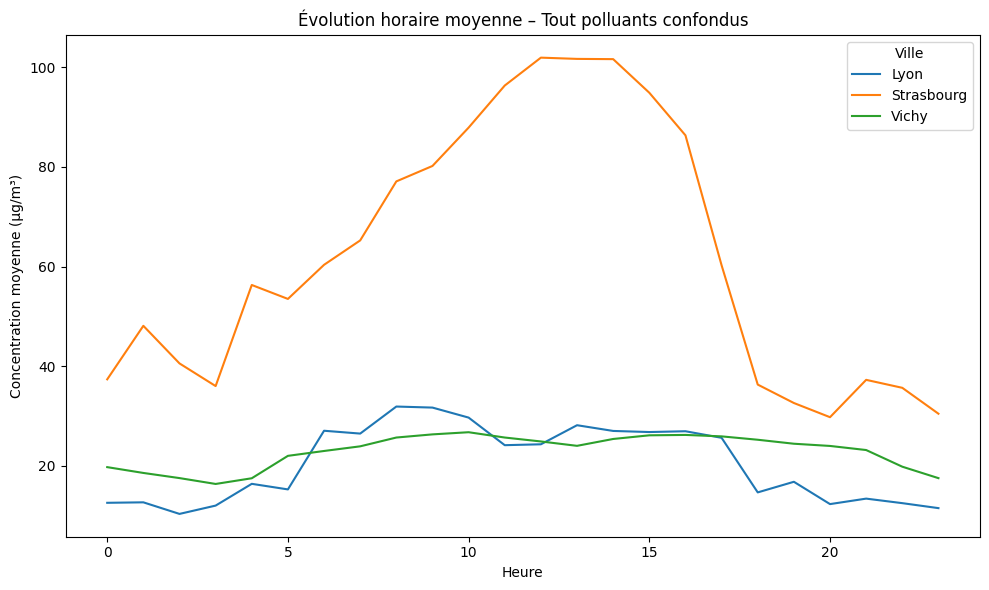

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_agg = df_pollution.groupby(['Heure', 'Ville'])['valeur'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_agg, x='Heure', y='valeur', hue='Ville')
plt.title("Évolution horaire moyenne – Tout polluants confondus")
plt.ylabel("Concentration moyenne (µg/m³)")
plt.xlabel("Heure")
plt.tight_layout()
plt.show()

By averaging all the pollutants combined over the four days, we can observe that the pollutant concentration in the Strasbourg conurbation is much higher than that of the other two conurbations. This is expected because Strasbourg is one of the five cities with the most polluted air in France https://www.greenwatt.fr/top-6-des-villes-les-plus-polluees-de-france/.

It is therefore no longer relevant to analyze the city of Strasbourg as the next location for TIC 2026. We therefore only analyze the agglomeration of Lyon and Vichy in this duel.

Global plot of mean concentration ln the whole week-end

The bar chart of averages below confirms the previous hypothesis with the advantage of visualizing the different time slots.

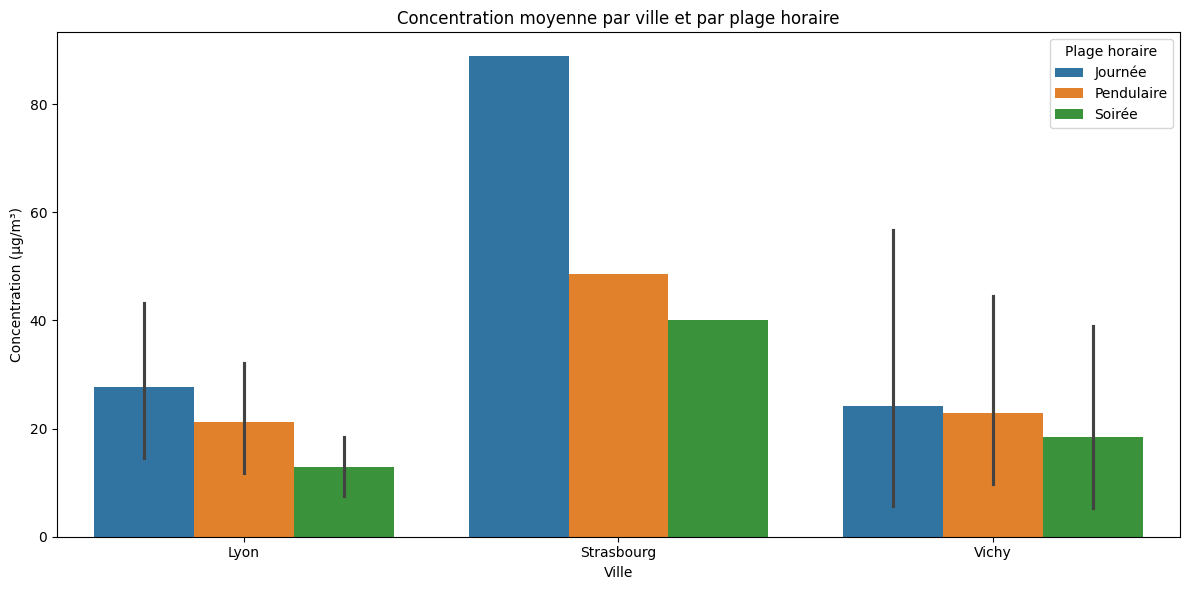

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=df_moyennes, x='Ville', y='Concentration (µg/m³)', hue='plage horaire')
plt.title("Concentration moyenne par ville et par plage horaire")
plt.ylabel("Concentration (µg/m³)")
plt.xlabel("Ville")
plt.legend(title="Plage horaire")
plt.tight_layout()
plt.show()

We therefore confirm that it is necessary to study the agglomerations of Lyon and Vichy more precisely than that of Strasbourg.

Mean pollution by time schedules

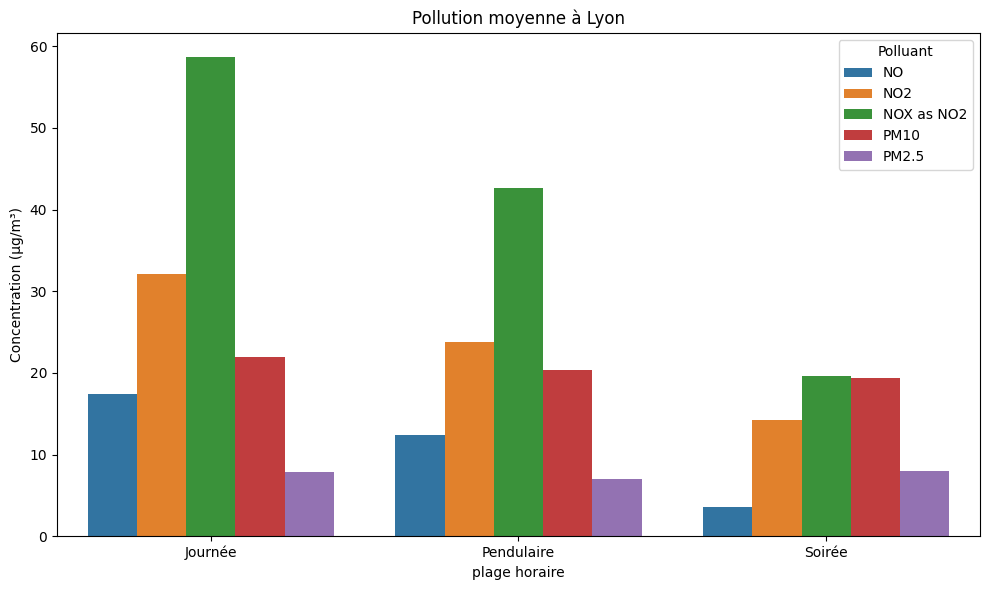

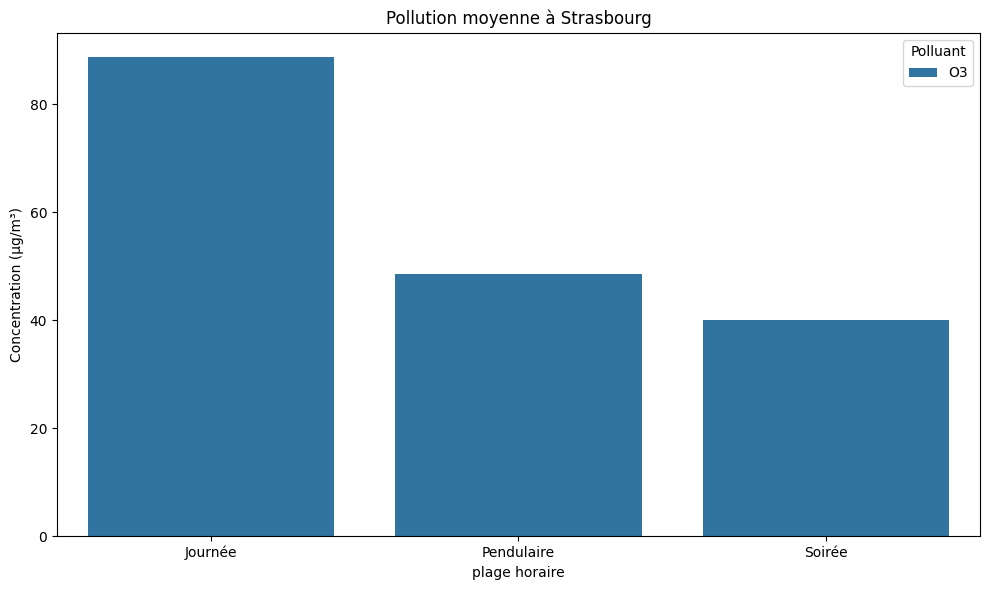

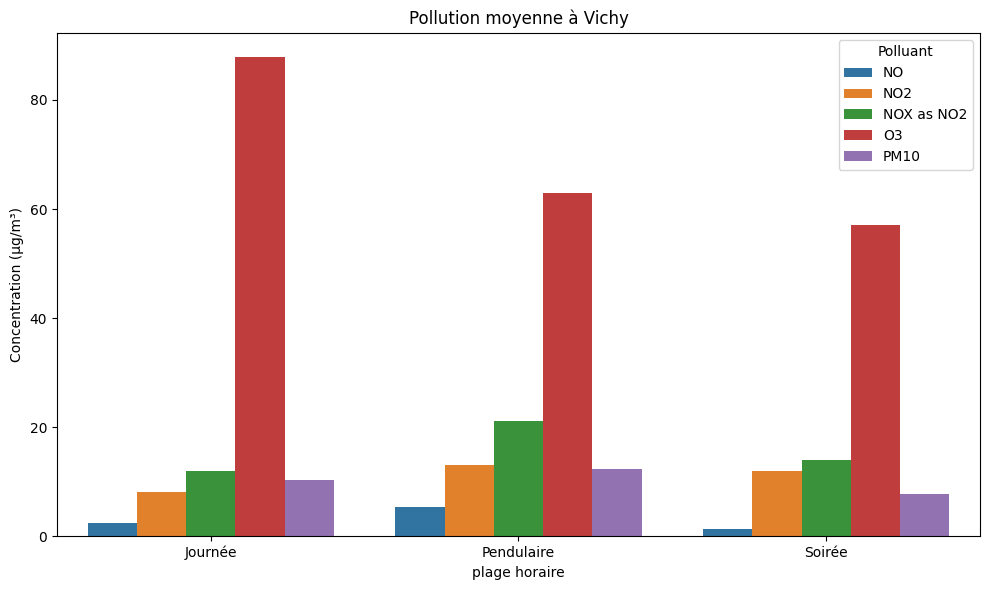

In [ ]:
for ville in df_moyennes['Ville'].unique():
    plt.figure(figsize=(10, 6))
    data = df_moyennes[df_moyennes['Ville'] == ville]
    sns.barplot(data=data, x='plage horaire', y='Concentration (µg/m³)', hue='Polluant')
    plt.title(f'Pollution moyenne à {ville}')
    plt.tight_layout()
    plt.show()

Concentration of pollutants (Boxplots)

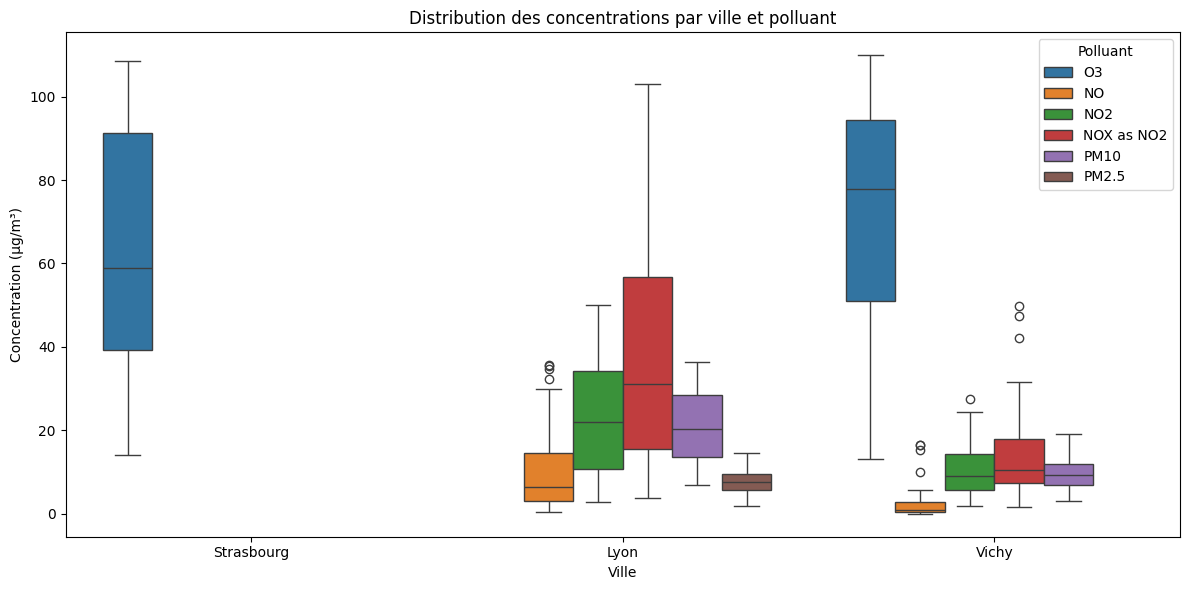

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pollution, x='Ville', y='valeur', hue='Polluant')
plt.title("Distribution des concentrations par ville et polluant")
plt.ylabel("Concentration (µg/m³)")
plt.xlabel("Ville")
plt.legend(title="Polluant")
plt.tight_layout()
plt.show()

Évolution horaire d’un polluant donné

Avant nettoyage : (502, 7)
Après nettoyage : (33, 4)


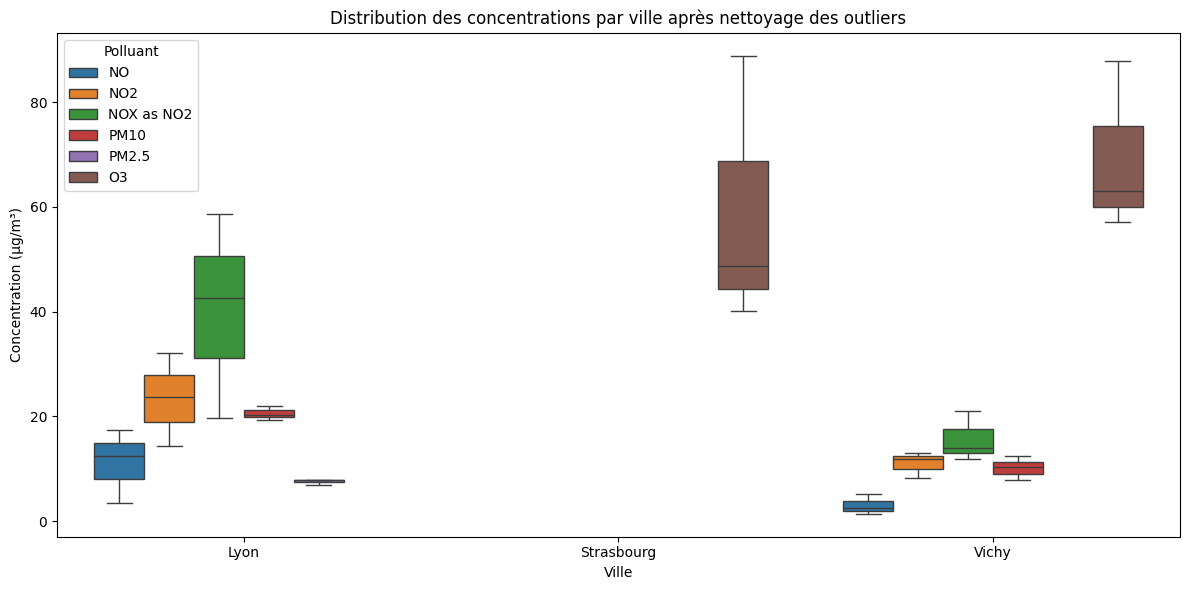

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers_visible_on_boxplot(df):
    cleaned_df = pd.DataFrame()

    # Processing for each city
    for (ville, polluant), group in df.groupby(['Ville', 'Polluant']):
        df_pollution['Concentration (µg/m³)'] = df_pollution['valeur']
        Q1 = group['Concentration (µg/m³)'].quantile(0.25)
        Q3 = group['Concentration (µg/m³)'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR

        # Data filter (Box Plot)
        filtered = group[(group['Concentration (µg/m³)'] >= lower_bound) & (group['Concentration (µg/m³)'] <= upper_bound)]
        cleaned_df = pd.concat([cleaned_df, filtered], ignore_index=True)

    return cleaned_df


df_pollution_sans_outliers = remove_outliers_visible_on_boxplot(df_moyennes)

# Comparison between pre and post filtration
print("Avant nettoyage :", df_pollution.shape)
print("Après nettoyage :", df_pollution_sans_outliers.shape)

df_clean = remove_outliers_visible_on_boxplot(df_pollution)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pollution_sans_outliers,
            x='Ville',
            y='Concentration (µg/m³)',
            hue='Polluant')
plt.title("Distribution des concentrations par ville après nettoyage des outliers")
plt.tight_layout()
plt.show()


Evolution of pollutants concentration

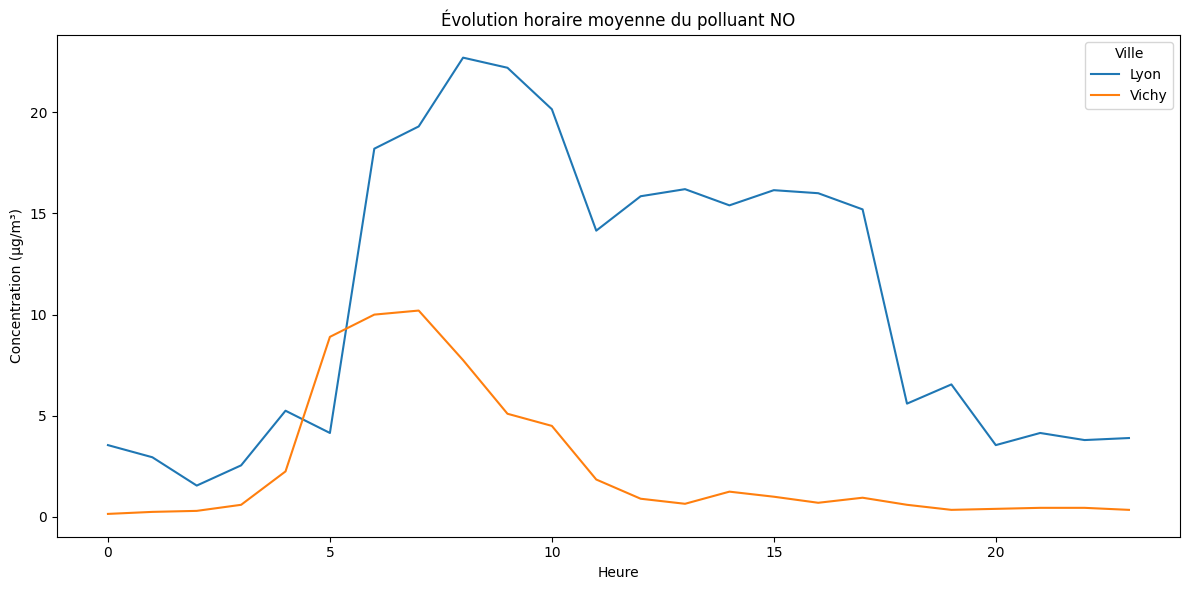

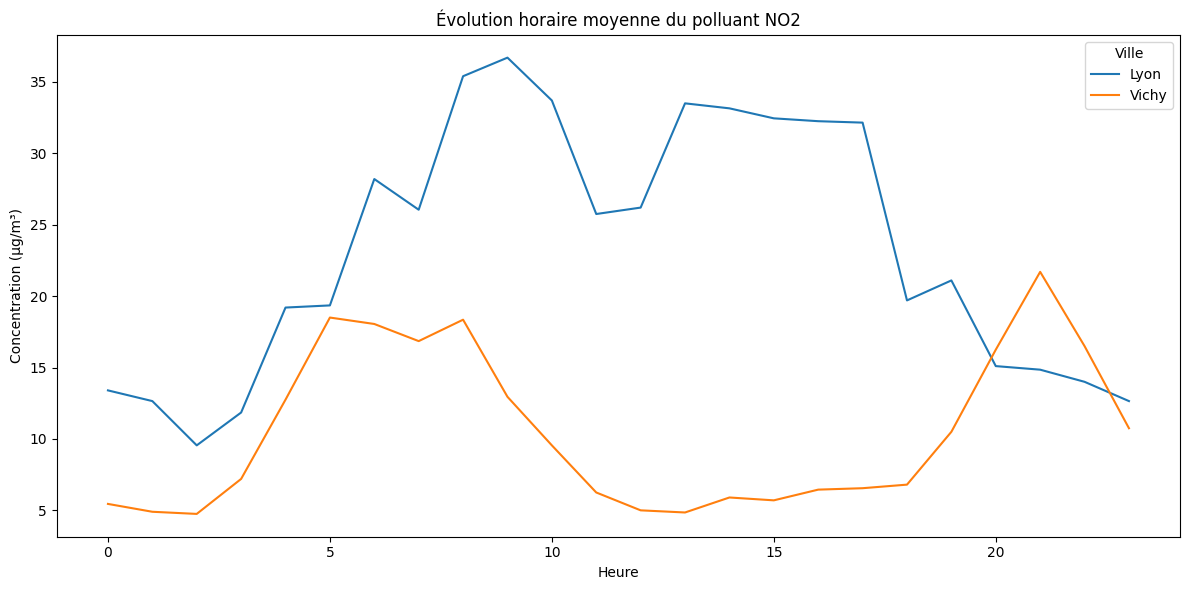

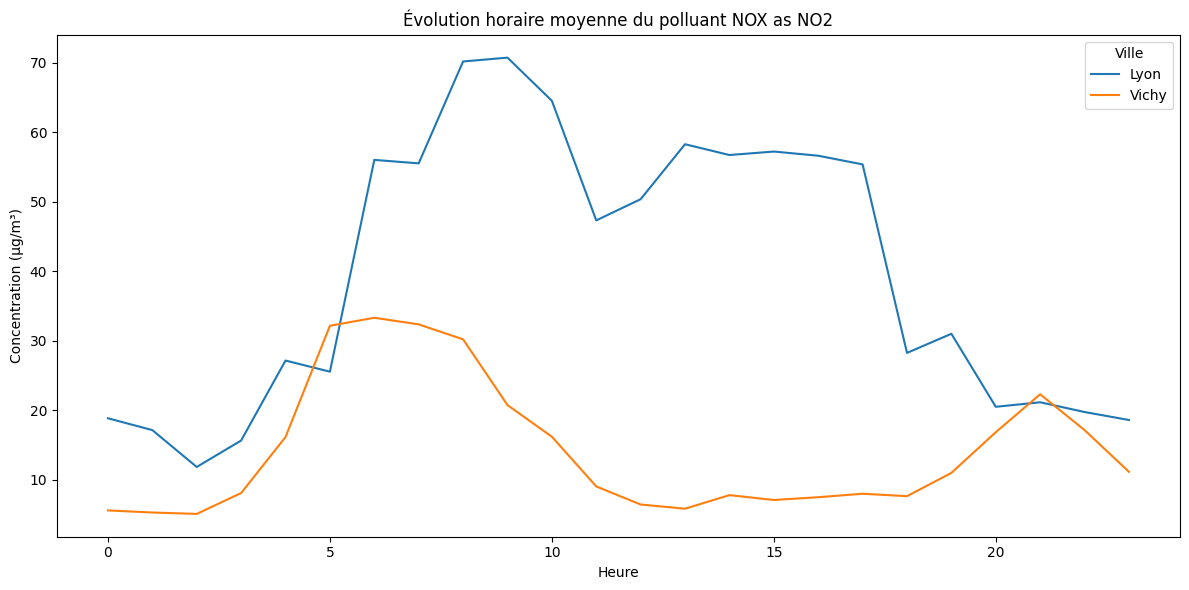

In [ ]:


polluant_cible = 'NO'
df_hourly = df_pollution[df_pollution['Polluant'] == polluant_cible].groupby(['Heure', 'Ville'])['valeur'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hourly, x='Heure', y='valeur', hue='Ville')
plt.title(f"Évolution horaire moyenne du polluant {polluant_cible}")
plt.xlabel("Heure")
plt.ylabel("Concentration (µg/m³)")
plt.tight_layout()
plt.show()

polluant_cible = 'NO2'
df_hourly = df_pollution[df_pollution['Polluant'] == polluant_cible].groupby(['Heure', 'Ville'])['valeur'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hourly, x='Heure', y='valeur', hue='Ville')
plt.title(f"Évolution horaire moyenne du polluant {polluant_cible}")
plt.xlabel("Heure")
plt.ylabel("Concentration (µg/m³)")
plt.tight_layout()
plt.show()

polluant_cible = 'NOX as NO2'
df_hourly = df_pollution[df_pollution['Polluant'] == polluant_cible].groupby(['Heure', 'Ville'])['valeur'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_hourly, x='Heure', y='valeur', hue='Ville')
plt.title(f"Évolution horaire moyenne du polluant {polluant_cible}")
plt.xlabel("Heure")
plt.ylabel("Concentration (µg/m³)")
plt.tight_layout()
plt.show()


Direct comparison of pollutants

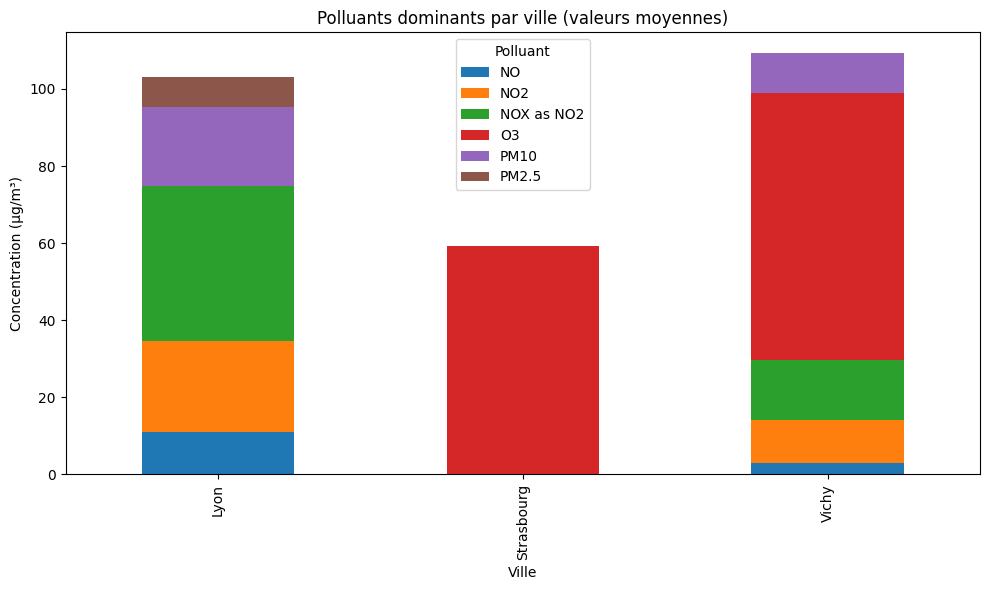

In [ ]:
dominants = df_moyennes.groupby(['Ville', 'Polluant'])['Concentration (µg/m³)'].mean().reset_index()
pivot_dom = dominants.pivot(index='Ville', columns='Polluant', values='Concentration (µg/m³)')

pivot_dom.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Polluants dominants par ville (valeurs moyennes)")
plt.ylabel("Concentration (µg/m³)")
plt.xlabel("Ville")
plt.legend(title="Polluant")
plt.tight_layout()
plt.show()

=== Régression causale horaire -> NO2 à Vichy ===
 Pente : 0.129 µg/m³/h
Corrélation : r = 0.151
 p-value : 3.051e-01
Pas de lien causal fort détecté ici.


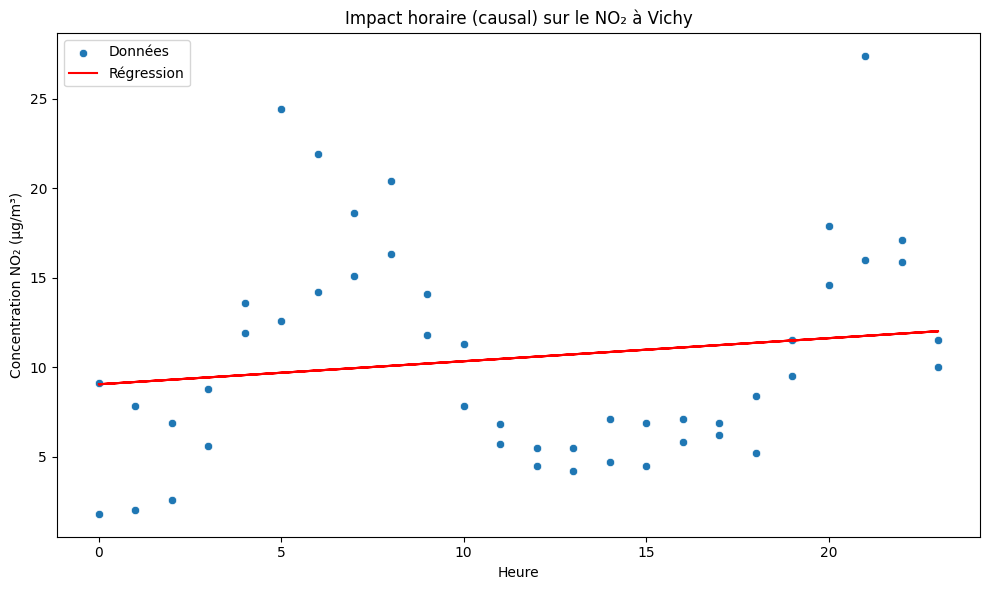

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


df_causal = df_pollution[(df_pollution['Ville'] == 'Vichy') & (df_pollution['Polluant'] == 'NO2')].copy()

X = df_causal[['Heure']]
y = df_causal['valeur']

#Linear Regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

#Pearson's correlation
corr, p = pearsonr(df_causal['Heure'], df_causal['valeur'])

print("=== Régression causale horaire -> NO2 à Vichy ===")
print(f" Pente : {model.coef_[0]:.3f} µg/m³/h")
olution of pollutants concentrationt(f"Corrélation : r = {corr:.3f}")
print(f" p-value : {p:.3e}")
if model.coef_[0] > 0 and p < 0.05:
    print(" Hypothèse causale confirmée : plus l'heure avance, plus le NO₂ augmente.")
else:
    print("Pas de lien causal fort détecté ici.")

# Vizualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_causal['Heure'], y=df_causal['valeur'], label="Données")
plt.plot(df_causal['Heure'], y_pred, color='red', label="Régression")
plt.title("Impact horaire (causal) sur le NO₂ à Vichy")
plt.xlabel("Heure")
plt.ylabel("Concentration NO₂ (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

By modeling the relationship between time and NO₂ concentration in Vichy, we do not obtain a significant positive correlation as we expected. This does not suggest a direct influence of increasing human activity on daytime pollution levels. Indeed, such a simple model cannot analyze such a complex situation, especially since we take pollution measurements on different sites.

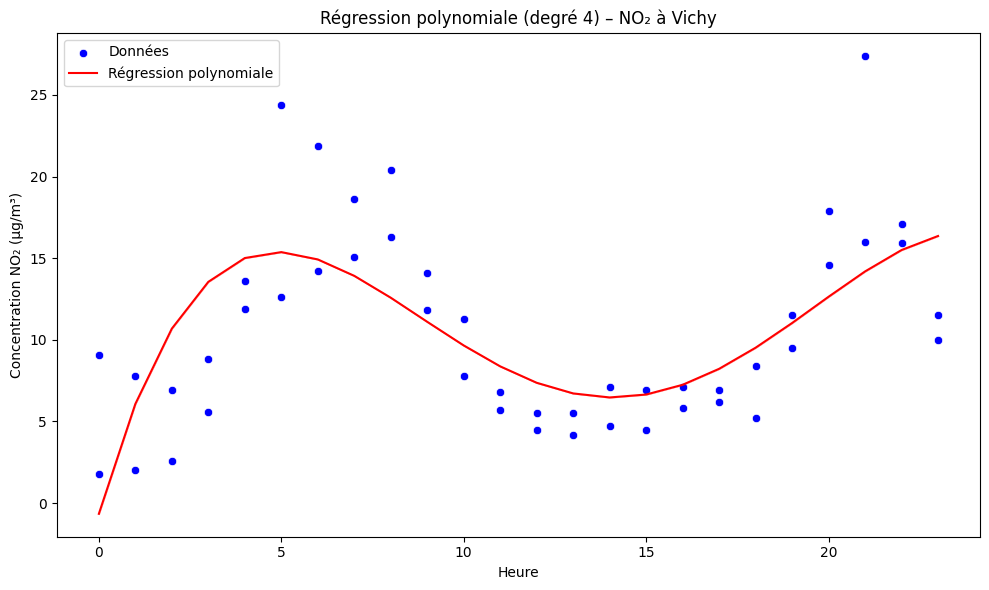

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data filters
df_vichy_no2 = df_pollution[(df_pollution['Ville'] == 'Vichy') & (df_pollution['Polluant'] == 'NO2')].copy()
X = df_vichy_no2[['Heure']]
y = df_vichy_no2['valeur']

# polynomial model fit
model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
model.fit(X, y)
y_pred = model.predict(X)

# Vizualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['Heure'], y=y, label="Données", color="blue")
sns.lineplot(x=X['Heure'], y=y_pred, label="Régression polynomiale", color="red")
plt.title("Régression polynomiale (degré 4) – NO₂ à Vichy")
plt.xlabel("Heure")
plt.ylabel("Concentration NO₂ (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans


df_vichy = df_pollution[df_pollution['Ville'] == 'Vichy']
df_kmeans = df_vichy.pivot_table(index='Heure', columns='Polluant', values='valeur', aggfunc='mean').dropna()

# Clustering
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
df_kmeans['Cluster'] = kmeans.fit_predict(df_kmeans)


print("Analyse des groupes horaires")
for cluster_id in sorted(df_kmeans['Cluster'].unique()):
    heures = df_kmeans[df_kmeans['Cluster'] == cluster_id].index.tolist()
    pollution_moyenne = df_kmeans[df_kmeans['Cluster'] == cluster_id].drop(columns='Cluster').mean()

    print(f" Cluster {cluster_id}")
    print(f" Heures concernées : {heures}")
    print(" Profil pollution :")
    for polluant, val in pollution_moyenne.items():
        print(f"   • {polluant} ≈ {val:.1f} µg/m³")
    print()

Analyse des groupes horaires
 Cluster 0
 Heures concernées : [4, 5, 6, 7, 8, 21, 22]
 Profil pollution :
   • NO ≈ 5.7 µg/m³
   • NO2 ≈ 17.5 µg/m³
   • NOX as NO2 ≈ 26.2 µg/m³
   • O3 ≈ 43.8 µg/m³
   • PM10 ≈ 12.7 µg/m³

 Cluster 1
 Heures concernées : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
 Profil pollution :
   • NO ≈ 1.3 µg/m³
   • NO2 ≈ 6.8 µg/m³
   • NOX as NO2 ≈ 8.7 µg/m³
   • O3 ≈ 93.4 µg/m³
   • PM10 ≈ 8.9 µg/m³

 Cluster 2
 Heures concernées : [0, 1, 2, 3, 9, 20, 23]
 Profil pollution :
   • NO ≈ 1.0 µg/m³
   • NO2 ≈ 8.9 µg/m³
   • NOX as NO2 ≈ 10.4 µg/m³
   • O3 ≈ 65.8 µg/m³
   • PM10 ≈ 7.6 µg/m³



### Data source

All CSV files used in this notebook are downloaded programmatically from the French open-data portal `data.gouv.fr`, using URLs of the form:

`https://files.data.gouv.fr/.../FR_E2_YYYY-MM-DD.csv`

Each file contains national background air-quality indicators (code `E2`) at hourly resolution for monitoring stations across France. In this project we filter these data to keep only the stations located in the selected urban areas.